## 1. 필요한 라이브러리 임포트

In [ ]:
# 주요 패키지
import numpy as np
import pandas as pd
import os 
from pathlib import Path
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

# 직접 개발한 패키지
from utils.config import CONFIG
from utils.visualize import visualize_data
from modules.input import TimeSeriesDownSampler

from training.model_training import create_lstm_autoencoder
from training.data_preprocessing import create_sequences
from lstmae import LSTMAutoencoder

# 딥러닝 프레임워크
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## 2. 데이터 로드 및 전처리 함수 정의

In [85]:
# 1. 세션 파일 로딩
def load_session(file_path):
    """
    단일 세션 데이터를 로드하는 함수
    file_path 경로의 데이터를 로드하여 가속도 데이터만을 골라
    데이터프레임으로 반환
    """
    df = pd.read_csv(file_path)
    # x, y, z 가속도 데이터만 선택
    return df[['accel_x', 'accel_y', 'accel_z']].values

In [86]:
# 2. 세션 하나(data)로 시퀀스들 생성
def create_sequences(data, sequence_length=30, step_size=5):
    """
    시계열 데이터를 시퀀스로 변환하는 함수
    데이터를 길이 30의 시퀀스들로 step size 5만큼 이동하며 생성
    생성된 시퀀스들의 배열을 반환
    """
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, step_size):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [87]:
# 3. 정상 시퀀스 생성
def prepare_normal_data(data_dir='../datas'):
    """
    각 세션별로 균등하게 분할하여 데이터셋 준비
    위 함수들을 이용해 데이터셋 준비
    세션-시퀀스 쌍 딕셔너리 배열을 만든 다음
    각 세션 별로 시퀀스들을 70:20:10으로 분할
    
    train sequence에 대해 스케일러 학습시키고
    이 스케일러로 validation seq, test seq도 적용용
    """
    data_dir = Path(data_dir)
    models_dir = Path('../models')
    # models 디렉토리가 없다면 생성
    models_dir.mkdir(exist_ok=True)
    
    # 각 세션별로 시퀀스 생성
    session_sequences = []
    for file_path in (data_dir / 'normal').glob('*.csv'):
        print(file_path)
        session_data = load_session(file_path)
        sequences = create_sequences(session_data)
        session_sequences.append({
            'file_name': file_path.name,
            'sequences': sequences
        })
    
    # 각 세션별로 70:20:10 분할
    train_sequences = []
    val_sequences = []
    test_sequences = []
    
    for session in session_sequences:
        sequences = session['sequences']
        n_sequences = len(sequences)
        
        # 인덱스 무작위 섞기
        indices = np.random.permutation(n_sequences)
        
        # 비율에 따라 분할
        n_train = int(n_sequences * 0.7)
        n_val = int(n_sequences * 0.2)
        
        train_idx = indices[:n_train]
        val_idx = indices[n_train:n_train + n_val]
        test_idx = indices[n_train + n_val:]
        
        train_sequences.append(sequences[train_idx])
        val_sequences.append(sequences[val_idx])
        test_sequences.append(sequences[test_idx])
        
        print(f"Session {session['file_name']}: {len(sequences)} sequences")
        print(f"  - Train: {len(train_idx)}")
        print(f"  - Val: {len(val_idx)}")
        print(f"  - Test: {len(test_idx)}")
    
    # 각 세트 내에서 세션 데이터 합치기
    train_sequences = np.concatenate(train_sequences)
    val_sequences = np.concatenate(val_sequences)
    test_sequences = np.concatenate(test_sequences)
    
    # 스케일러 학습 (훈련 데이터만 사용)
    scaler = StandardScaler()
    train_sequences_2d = train_sequences.reshape(-1, train_sequences.shape[-1])
    scaler.fit(train_sequences_2d)
    
    # 스케일러 저장
    scaler_path = models_dir / 'scaler.joblib'
    dump(scaler, scaler_path)
    print(f"\nScaler saved to {scaler_path}")
    
    def scale_sequences(sequences):
        original_shape = sequences.shape
        sequences_2d = sequences.reshape(-1, sequences.shape[-1])
        scaled_2d = scaler.transform(sequences_2d)
        return scaled_2d.reshape(original_shape)
    
    # 모든 데이터 스케일링
    train_sequences_scaled = scale_sequences(train_sequences)
    val_sequences_scaled = scale_sequences(val_sequences)
    test_sequences_scaled = scale_sequences(test_sequences)
    
    return {
        'train': train_sequences_scaled,
        'val': val_sequences_scaled,
        'test_normal': test_sequences_scaled,
        'scaler': scaler
    }

In [88]:
# 4. 테스트 시퀀스 준비
def prepare_test_data(data_dir='../datas'):
    """저장된 스케일러를 사용하여 테스트 데이터를 준비하는 함수"""
    scaler_dir = Path('../models')
    data_dir = Path(data_dir)
    # 저장된 스케일러 로드
    scaler_path = scaler_dir / 'scaler.joblib'
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler file not found at {scaler_path}")
    scaler = load(scaler_path)
    
    # 이상치 데이터 로드
    abnormal_sequences = []
    for file_path in (data_dir / 'abnormal').glob('*.csv'):
        print(file_path)
        session_data = load_session(file_path)
        sequences = create_sequences(session_data)
        abnormal_sequences.extend(sequences)
    abnormal_sequences = np.array(abnormal_sequences)
    
    # 이상치 데이터 스케일링
    def scale_sequences(sequences):
        original_shape = sequences.shape
        sequences_2d = sequences.reshape(-1, sequences.shape[-1])
        scaled_2d = scaler.transform(sequences_2d)
        return scaled_2d.reshape(original_shape)
    
    abnormal_sequences_scaled = scale_sequences(abnormal_sequences)
    
    return {'abnormal': abnormal_sequences_scaled}

In [89]:
# 5. 스케일러 로딩
def load_scaler(models_dir='models'):
    """저장된 스케일러를 불러오는 함수"""
    scaler_path = Path(models_dir) / 'scaler.joblib'
    if not scaler_path.exists():
        raise FileNotFoundError(f"Scaler file not found at {scaler_path}")
    return load(scaler_path)

In [90]:
# 6. 데이터셋 클래스
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.FloatTensor(sequences)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

## 3. 모델 클래스 정의

## 4. 모델 학습 함수 정의

In [92]:
def train_model(model, train_loader, val_loader, 
                n_epochs=100, learning_rate=1e-3, 
                device='cuda' if torch.cuda.is_available() else 'cpu',
                patience=10, model_save_path='../models/autoencoder.pth'):
    """
    LSTM Autoencoder 모델 훈련 함수
    
    Args:
        model: LSTM Autoencoder 모델
        train_loader: 훈련 데이터 로더
        val_loader: 검증 데이터 로더
        n_epochs: 전체 에포크 수
        learning_rate: 학습률
        device: 학습 디바이스 (CPU/GPU)
        patience: Early stopping patience
        model_save_path: 모델 저장 경로
    """
    # 모델을 지정된 디바이스로 이동
    model = model.to(device)
    
    # 손실 함수와 옵티마이저 정의
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Early stopping 관련 변수들
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop = False
    
    # 훈련 과정 모니터링을 위한 리스트
    train_losses = []
    val_losses = []
    
    # 모델 저장 경로 설정
    model_save_path = Path(model_save_path)
    model_save_path.parent.mkdir(exist_ok=True)
    
    for epoch in range(n_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_batches = 0
        
        # 훈련 루프
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
            batch = batch.to(device)
            
            # 순전파
            output = model(batch)
            loss = criterion(output, batch)
            
            # 역전파 및 옵티마이저 스텝
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        # 에포크당 평균 훈련 손실 계산
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output, batch)
                val_loss += loss.item()
                val_batches += 1
        
        # 에포크당 평균 검증 손실 계산
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # 현재 상태 출력
        print(f'Epoch [{epoch+1}/{n_epochs}]')
        print(f'  Training Loss: {avg_train_loss:.6f}')
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        
        # Early stopping 체크
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # 최상의 모델 저장
            torch.save(model.state_dict(), model_save_path)
            print(f'  Model saved to {model_save_path}')
        else:
            patience_counter += 1
            print(f'  EarlyStopping counter: {patience_counter} out of {patience}')
            
        if patience_counter >= patience:
            print('Early stopping triggered')
            early_stop = True
            break
    
    # 학습 과정 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

def load_trained_model(model, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    저장된 모델 가중치를 로드하는 함수
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [93]:
def evaluate_model(model, test_loader, test_labels, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    모델 평가 및 다양한 메트릭 계산/시각화
    
    Args:
        model: 학습된 LSTM Autoencoder 모델
        test_loader: 테스트 데이터 로더
        test_labels: 테스트 데이터의 실제 레이블 (0: 정상, 1: 이상)
        device: 평가 수행할 디바이스
    """
    model.eval()
    reconstruction_errors = []
    
    # 재구성 오차 계산
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            # 각 샘플의 재구성 오차 계산
            errors = torch.mean((batch - output) ** 2, dim=(1, 2))
            reconstruction_errors.extend(errors.cpu().numpy())
    
    reconstruction_errors = np.array(reconstruction_errors)
    
    # 1. 재구성 오차 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors[test_labels == 0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(reconstruction_errors[test_labels == 1], bins=50, alpha=0.5, label='Anomaly', density=True)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.show()
    
    # 2. ROC 커브
    fpr, tpr, roc_thresholds = roc_curve(test_labels, reconstruction_errors)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # 3. Precision-Recall 커브
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, reconstruction_errors)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # 4. 최적 임계값 찾기
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_threshold_idx = np.argmax(f1_scores)
    optimal_threshold = pr_thresholds[optimal_threshold_idx]
    
    # 5. 혼동 행렬
    predictions = (reconstruction_errors >= optimal_threshold).astype(int)
    cm = confusion_matrix(test_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (threshold = {optimal_threshold:.4f})')
    plt.show()
    
    # 6. 성능 지표 계산
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    f1 = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    
    print("\nPerformance Metrics:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"Recall: {recall_score:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    return {
        'reconstruction_errors': reconstruction_errors,
        'optimal_threshold': optimal_threshold,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'f1_score': f1
    }

## 5. 학습 및 테스트 진행

../datas/normal/downsampled_600-8_loss.csv
../datas/normal/downsampled_600-9.csv
../datas/normal/downsampled_600-3.csv
../datas/normal/downsampled_600-2.csv
../datas/normal/downsampled_600-1.csv
../datas/normal/600-11-1.csv
../datas/normal/downsampled_600-6.csv
Session downsampled_600-8_loss.csv: 354 sequences
  - Train: 247
  - Val: 70
  - Test: 37
Session downsampled_600-9.csv: 355 sequences
  - Train: 248
  - Val: 71
  - Test: 36
Session downsampled_600-3.csv: 355 sequences
  - Train: 248
  - Val: 71
  - Test: 36
Session downsampled_600-2.csv: 355 sequences
  - Train: 248
  - Val: 71
  - Test: 36
Session downsampled_600-1.csv: 355 sequences
  - Train: 248
  - Val: 71
  - Test: 36
Session 600-11-1.csv: 301 sequences
  - Train: 210
  - Val: 60
  - Test: 31
Session downsampled_600-6.csv: 355 sequences
  - Train: 248
  - Val: 71
  - Test: 36

Scaler saved to ../models/scaler.joblib
../datas/abnormal/600-11-2.csv
../datas/abnormal/600-11-3.csv


Epoch 1/100: 100%|██████████| 54/54 [00:00<00:00, 641.30it/s]


Epoch [1/100]
  Training Loss: 0.759579
  Validation Loss: 0.552615
  Model saved to ../models/autoencoder.pth


Epoch 2/100: 100%|██████████| 54/54 [00:00<00:00, 664.43it/s]


Epoch [2/100]
  Training Loss: 0.555642
  Validation Loss: 0.535066
  Model saved to ../models/autoencoder.pth


Epoch 3/100: 100%|██████████| 54/54 [00:00<00:00, 660.54it/s]


Epoch [3/100]
  Training Loss: 0.543055
  Validation Loss: 0.530827
  Model saved to ../models/autoencoder.pth


Epoch 4/100: 100%|██████████| 54/54 [00:00<00:00, 657.49it/s]


Epoch [4/100]
  Training Loss: 0.537377
  Validation Loss: 0.524085
  Model saved to ../models/autoencoder.pth


Epoch 5/100: 100%|██████████| 54/54 [00:00<00:00, 684.65it/s]


Epoch [5/100]
  Training Loss: 0.529382
  Validation Loss: 0.521164
  Model saved to ../models/autoencoder.pth


Epoch 6/100: 100%|██████████| 54/54 [00:00<00:00, 671.11it/s]


Epoch [6/100]
  Training Loss: 0.541996
  Validation Loss: 0.520021
  Model saved to ../models/autoencoder.pth


Epoch 7/100: 100%|██████████| 54/54 [00:00<00:00, 694.52it/s]


Epoch [7/100]
  Training Loss: 0.530369
  Validation Loss: 0.517717
  Model saved to ../models/autoencoder.pth


Epoch 8/100: 100%|██████████| 54/54 [00:00<00:00, 662.71it/s]


Epoch [8/100]
  Training Loss: 0.525321
  Validation Loss: 0.514214
  Model saved to ../models/autoencoder.pth


Epoch 9/100: 100%|██████████| 54/54 [00:00<00:00, 603.85it/s]


Epoch [9/100]
  Training Loss: 0.527996
  Validation Loss: 0.512841
  Model saved to ../models/autoencoder.pth


Epoch 10/100: 100%|██████████| 54/54 [00:00<00:00, 698.70it/s]


Epoch [10/100]
  Training Loss: 0.523210
  Validation Loss: 0.511951
  Model saved to ../models/autoencoder.pth


Epoch 11/100: 100%|██████████| 54/54 [00:00<00:00, 680.95it/s]


Epoch [11/100]
  Training Loss: 0.517813
  Validation Loss: 0.511544
  Model saved to ../models/autoencoder.pth


Epoch 12/100: 100%|██████████| 54/54 [00:00<00:00, 702.17it/s]


Epoch [12/100]
  Training Loss: 0.518231
  Validation Loss: 0.512012
  EarlyStopping counter: 1 out of 10


Epoch 13/100: 100%|██████████| 54/54 [00:00<00:00, 695.76it/s]


Epoch [13/100]
  Training Loss: 0.524964
  Validation Loss: 0.510935
  Model saved to ../models/autoencoder.pth


Epoch 14/100: 100%|██████████| 54/54 [00:00<00:00, 637.13it/s]


Epoch [14/100]
  Training Loss: 0.517831
  Validation Loss: 0.517091
  EarlyStopping counter: 1 out of 10


Epoch 15/100: 100%|██████████| 54/54 [00:00<00:00, 693.27it/s]


Epoch [15/100]
  Training Loss: 0.536285
  Validation Loss: 0.548396
  EarlyStopping counter: 2 out of 10


Epoch 16/100: 100%|██████████| 54/54 [00:00<00:00, 681.70it/s]


Epoch [16/100]
  Training Loss: 0.535199
  Validation Loss: 0.523469
  EarlyStopping counter: 3 out of 10


Epoch 17/100: 100%|██████████| 54/54 [00:00<00:00, 640.04it/s]


Epoch [17/100]
  Training Loss: 0.519347
  Validation Loss: 0.510198
  Model saved to ../models/autoencoder.pth


Epoch 18/100: 100%|██████████| 54/54 [00:00<00:00, 699.79it/s]


Epoch [18/100]
  Training Loss: 0.516118
  Validation Loss: 0.512885
  EarlyStopping counter: 1 out of 10


Epoch 19/100: 100%|██████████| 54/54 [00:00<00:00, 687.76it/s]


Epoch [19/100]
  Training Loss: 0.521167
  Validation Loss: 0.508395
  Model saved to ../models/autoencoder.pth


Epoch 20/100: 100%|██████████| 54/54 [00:00<00:00, 615.16it/s]


Epoch [20/100]
  Training Loss: 0.513963
  Validation Loss: 0.508604
  EarlyStopping counter: 1 out of 10


Epoch 21/100: 100%|██████████| 54/54 [00:00<00:00, 696.39it/s]


Epoch [21/100]
  Training Loss: 0.523922
  Validation Loss: 0.511248
  EarlyStopping counter: 2 out of 10


Epoch 22/100: 100%|██████████| 54/54 [00:00<00:00, 692.43it/s]


Epoch [22/100]
  Training Loss: 0.516002
  Validation Loss: 0.507919
  Model saved to ../models/autoencoder.pth


Epoch 23/100: 100%|██████████| 54/54 [00:00<00:00, 699.76it/s]


Epoch [23/100]
  Training Loss: 0.517287
  Validation Loss: 0.507872
  Model saved to ../models/autoencoder.pth


Epoch 24/100: 100%|██████████| 54/54 [00:00<00:00, 644.93it/s]


Epoch [24/100]
  Training Loss: 0.516117
  Validation Loss: 0.504765
  Model saved to ../models/autoencoder.pth


Epoch 25/100: 100%|██████████| 54/54 [00:00<00:00, 675.44it/s]


Epoch [25/100]
  Training Loss: 0.511194
  Validation Loss: 0.504434
  Model saved to ../models/autoencoder.pth


Epoch 26/100: 100%|██████████| 54/54 [00:00<00:00, 694.94it/s]


Epoch [26/100]
  Training Loss: 0.518209
  Validation Loss: 0.503264
  Model saved to ../models/autoencoder.pth


Epoch 27/100: 100%|██████████| 54/54 [00:00<00:00, 699.99it/s]


Epoch [27/100]
  Training Loss: 0.512089
  Validation Loss: 0.502322
  Model saved to ../models/autoencoder.pth


Epoch 28/100: 100%|██████████| 54/54 [00:00<00:00, 597.44it/s]


Epoch [28/100]
  Training Loss: 0.508836
  Validation Loss: 0.499945
  Model saved to ../models/autoencoder.pth


Epoch 29/100: 100%|██████████| 54/54 [00:00<00:00, 691.21it/s]


Epoch [29/100]
  Training Loss: 0.505551
  Validation Loss: 0.500079
  EarlyStopping counter: 1 out of 10


Epoch 30/100: 100%|██████████| 54/54 [00:00<00:00, 598.46it/s]


Epoch [30/100]
  Training Loss: 0.512858
  Validation Loss: 0.498015
  Model saved to ../models/autoencoder.pth


Epoch 31/100: 100%|██████████| 54/54 [00:00<00:00, 638.97it/s]


Epoch [31/100]
  Training Loss: 0.517142
  Validation Loss: 0.498932
  EarlyStopping counter: 1 out of 10


Epoch 32/100: 100%|██████████| 54/54 [00:00<00:00, 500.56it/s]


Epoch [32/100]
  Training Loss: 0.510922
  Validation Loss: 0.502915
  EarlyStopping counter: 2 out of 10


Epoch 33/100: 100%|██████████| 54/54 [00:00<00:00, 658.67it/s]


Epoch [33/100]
  Training Loss: 0.505072
  Validation Loss: 0.499325
  EarlyStopping counter: 3 out of 10


Epoch 34/100: 100%|██████████| 54/54 [00:00<00:00, 692.18it/s]


Epoch [34/100]
  Training Loss: 0.506158
  Validation Loss: 0.495248
  Model saved to ../models/autoencoder.pth


Epoch 35/100: 100%|██████████| 54/54 [00:00<00:00, 688.39it/s]


Epoch [35/100]
  Training Loss: 0.511918
  Validation Loss: 0.496895
  EarlyStopping counter: 1 out of 10


Epoch 36/100: 100%|██████████| 54/54 [00:00<00:00, 606.95it/s]


Epoch [36/100]
  Training Loss: 0.499740
  Validation Loss: 0.495057
  Model saved to ../models/autoencoder.pth


Epoch 37/100: 100%|██████████| 54/54 [00:00<00:00, 658.28it/s]


Epoch [37/100]
  Training Loss: 0.500916
  Validation Loss: 0.495030
  Model saved to ../models/autoencoder.pth


Epoch 38/100: 100%|██████████| 54/54 [00:00<00:00, 689.14it/s]


Epoch [38/100]
  Training Loss: 0.507209
  Validation Loss: 0.492077
  Model saved to ../models/autoencoder.pth


Epoch 39/100: 100%|██████████| 54/54 [00:00<00:00, 540.82it/s]


Epoch [39/100]
  Training Loss: 0.506053
  Validation Loss: 0.488965
  Model saved to ../models/autoencoder.pth


Epoch 40/100: 100%|██████████| 54/54 [00:00<00:00, 684.25it/s]


Epoch [40/100]
  Training Loss: 0.494936
  Validation Loss: 0.488464
  Model saved to ../models/autoencoder.pth


Epoch 41/100: 100%|██████████| 54/54 [00:00<00:00, 686.62it/s]


Epoch [41/100]
  Training Loss: 0.492944
  Validation Loss: 0.486479
  Model saved to ../models/autoencoder.pth


Epoch 42/100: 100%|██████████| 54/54 [00:00<00:00, 597.24it/s]


Epoch [42/100]
  Training Loss: 0.492565
  Validation Loss: 0.485512
  Model saved to ../models/autoencoder.pth


Epoch 43/100: 100%|██████████| 54/54 [00:00<00:00, 688.87it/s]


Epoch [43/100]
  Training Loss: 0.491168
  Validation Loss: 0.484255
  Model saved to ../models/autoencoder.pth


Epoch 44/100: 100%|██████████| 54/54 [00:00<00:00, 689.26it/s]


Epoch [44/100]
  Training Loss: 0.497896
  Validation Loss: 0.481110
  Model saved to ../models/autoencoder.pth


Epoch 45/100: 100%|██████████| 54/54 [00:00<00:00, 667.66it/s]


Epoch [45/100]
  Training Loss: 0.486880
  Validation Loss: 0.478669
  Model saved to ../models/autoencoder.pth


Epoch 46/100: 100%|██████████| 54/54 [00:00<00:00, 601.98it/s]


Epoch [46/100]
  Training Loss: 0.483977
  Validation Loss: 0.477464
  Model saved to ../models/autoencoder.pth


Epoch 47/100: 100%|██████████| 54/54 [00:00<00:00, 644.61it/s]


Epoch [47/100]
  Training Loss: 0.480997
  Validation Loss: 0.473992
  Model saved to ../models/autoencoder.pth


Epoch 48/100: 100%|██████████| 54/54 [00:00<00:00, 703.14it/s]


Epoch [48/100]
  Training Loss: 0.483756
  Validation Loss: 0.475361
  EarlyStopping counter: 1 out of 10


Epoch 49/100: 100%|██████████| 54/54 [00:00<00:00, 703.12it/s]


Epoch [49/100]
  Training Loss: 0.489779
  Validation Loss: 0.476594
  EarlyStopping counter: 2 out of 10


Epoch 50/100: 100%|██████████| 54/54 [00:00<00:00, 704.24it/s]


Epoch [50/100]
  Training Loss: 0.480327
  Validation Loss: 0.470601
  Model saved to ../models/autoencoder.pth


Epoch 51/100: 100%|██████████| 54/54 [00:00<00:00, 695.58it/s]


Epoch [51/100]
  Training Loss: 0.480221
  Validation Loss: 0.475030
  EarlyStopping counter: 1 out of 10


Epoch 52/100: 100%|██████████| 54/54 [00:00<00:00, 695.09it/s]


Epoch [52/100]
  Training Loss: 0.484500
  Validation Loss: 0.467162
  Model saved to ../models/autoencoder.pth


Epoch 53/100: 100%|██████████| 54/54 [00:00<00:00, 547.84it/s]


Epoch [53/100]
  Training Loss: 0.470367
  Validation Loss: 0.466540
  Model saved to ../models/autoencoder.pth


Epoch 54/100: 100%|██████████| 54/54 [00:00<00:00, 607.72it/s]


Epoch [54/100]
  Training Loss: 0.470499
  Validation Loss: 0.464227
  Model saved to ../models/autoencoder.pth


Epoch 55/100: 100%|██████████| 54/54 [00:00<00:00, 631.79it/s]


Epoch [55/100]
  Training Loss: 0.468329
  Validation Loss: 0.461227
  Model saved to ../models/autoencoder.pth


Epoch 56/100: 100%|██████████| 54/54 [00:00<00:00, 531.10it/s]


Epoch [56/100]
  Training Loss: 0.463062
  Validation Loss: 0.457316
  Model saved to ../models/autoencoder.pth


Epoch 57/100: 100%|██████████| 54/54 [00:00<00:00, 579.67it/s]


Epoch [57/100]
  Training Loss: 0.461805
  Validation Loss: 0.454187
  Model saved to ../models/autoencoder.pth


Epoch 58/100: 100%|██████████| 54/54 [00:00<00:00, 645.60it/s]


Epoch [58/100]
  Training Loss: 0.463004
  Validation Loss: 0.454986
  EarlyStopping counter: 1 out of 10


Epoch 59/100: 100%|██████████| 54/54 [00:00<00:00, 657.45it/s]


Epoch [59/100]
  Training Loss: 0.460108
  Validation Loss: 0.456269
  EarlyStopping counter: 2 out of 10


Epoch 60/100: 100%|██████████| 54/54 [00:00<00:00, 657.92it/s]


Epoch [60/100]
  Training Loss: 0.455277
  Validation Loss: 0.450639
  Model saved to ../models/autoencoder.pth


Epoch 61/100: 100%|██████████| 54/54 [00:00<00:00, 659.77it/s]


Epoch [61/100]
  Training Loss: 0.455458
  Validation Loss: 0.450098
  Model saved to ../models/autoencoder.pth


Epoch 62/100: 100%|██████████| 54/54 [00:00<00:00, 655.71it/s]


Epoch [62/100]
  Training Loss: 0.464015
  Validation Loss: 0.450100
  EarlyStopping counter: 1 out of 10


Epoch 63/100: 100%|██████████| 54/54 [00:00<00:00, 660.75it/s]


Epoch [63/100]
  Training Loss: 0.456939
  Validation Loss: 0.453320
  EarlyStopping counter: 2 out of 10


Epoch 64/100: 100%|██████████| 54/54 [00:00<00:00, 575.55it/s]


Epoch [64/100]
  Training Loss: 0.462680
  Validation Loss: 0.452114
  EarlyStopping counter: 3 out of 10


Epoch 65/100: 100%|██████████| 54/54 [00:00<00:00, 636.96it/s]


Epoch [65/100]
  Training Loss: 0.454134
  Validation Loss: 0.444451
  Model saved to ../models/autoencoder.pth


Epoch 66/100: 100%|██████████| 54/54 [00:00<00:00, 636.43it/s]


Epoch [66/100]
  Training Loss: 0.445104
  Validation Loss: 0.439569
  Model saved to ../models/autoencoder.pth


Epoch 67/100: 100%|██████████| 54/54 [00:00<00:00, 620.29it/s]


Epoch [67/100]
  Training Loss: 0.453223
  Validation Loss: 0.439979
  EarlyStopping counter: 1 out of 10


Epoch 68/100: 100%|██████████| 54/54 [00:00<00:00, 573.68it/s]


Epoch [68/100]
  Training Loss: 0.447784
  Validation Loss: 0.435884
  Model saved to ../models/autoencoder.pth


Epoch 69/100: 100%|██████████| 54/54 [00:00<00:00, 623.15it/s]


Epoch [69/100]
  Training Loss: 0.450602
  Validation Loss: 0.436354
  EarlyStopping counter: 1 out of 10


Epoch 70/100: 100%|██████████| 54/54 [00:00<00:00, 591.48it/s]


Epoch [70/100]
  Training Loss: 0.446040
  Validation Loss: 0.434949
  Model saved to ../models/autoencoder.pth


Epoch 71/100: 100%|██████████| 54/54 [00:00<00:00, 501.54it/s]


Epoch [71/100]
  Training Loss: 0.445205
  Validation Loss: 0.437911
  EarlyStopping counter: 1 out of 10


Epoch 72/100: 100%|██████████| 54/54 [00:00<00:00, 539.90it/s]


Epoch [72/100]
  Training Loss: 0.437654
  Validation Loss: 0.431603
  Model saved to ../models/autoencoder.pth


Epoch 73/100: 100%|██████████| 54/54 [00:00<00:00, 567.90it/s]


Epoch [73/100]
  Training Loss: 0.436512
  Validation Loss: 0.431748
  EarlyStopping counter: 1 out of 10


Epoch 74/100: 100%|██████████| 54/54 [00:00<00:00, 599.35it/s]


Epoch [74/100]
  Training Loss: 0.435851
  Validation Loss: 0.427390
  Model saved to ../models/autoencoder.pth


Epoch 75/100: 100%|██████████| 54/54 [00:00<00:00, 546.60it/s]


Epoch [75/100]
  Training Loss: 0.439332
  Validation Loss: 0.430530
  EarlyStopping counter: 1 out of 10


Epoch 76/100: 100%|██████████| 54/54 [00:00<00:00, 540.57it/s]


Epoch [76/100]
  Training Loss: 0.437429
  Validation Loss: 0.429106
  EarlyStopping counter: 2 out of 10


Epoch 77/100: 100%|██████████| 54/54 [00:00<00:00, 539.63it/s]


Epoch [77/100]
  Training Loss: 0.428836
  Validation Loss: 0.424758
  Model saved to ../models/autoencoder.pth


Epoch 78/100: 100%|██████████| 54/54 [00:00<00:00, 599.52it/s]


Epoch [78/100]
  Training Loss: 0.436974
  Validation Loss: 0.436377
  EarlyStopping counter: 1 out of 10


Epoch 79/100: 100%|██████████| 54/54 [00:00<00:00, 650.16it/s]


Epoch [79/100]
  Training Loss: 0.440482
  Validation Loss: 0.421207
  Model saved to ../models/autoencoder.pth


Epoch 80/100: 100%|██████████| 54/54 [00:00<00:00, 680.16it/s]


Epoch [80/100]
  Training Loss: 0.424629
  Validation Loss: 0.421488
  EarlyStopping counter: 1 out of 10


Epoch 81/100: 100%|██████████| 54/54 [00:00<00:00, 666.86it/s]


Epoch [81/100]
  Training Loss: 0.422724
  Validation Loss: 0.417442
  Model saved to ../models/autoencoder.pth


Epoch 82/100: 100%|██████████| 54/54 [00:00<00:00, 669.34it/s]


Epoch [82/100]
  Training Loss: 0.425803
  Validation Loss: 0.419878
  EarlyStopping counter: 1 out of 10


Epoch 83/100: 100%|██████████| 54/54 [00:00<00:00, 703.50it/s]


Epoch [83/100]
  Training Loss: 0.436091
  Validation Loss: 0.415300
  Model saved to ../models/autoencoder.pth


Epoch 84/100: 100%|██████████| 54/54 [00:00<00:00, 700.53it/s]


Epoch [84/100]
  Training Loss: 0.428336
  Validation Loss: 0.414851
  Model saved to ../models/autoencoder.pth


Epoch 85/100: 100%|██████████| 54/54 [00:00<00:00, 639.18it/s]


Epoch [85/100]
  Training Loss: 0.423020
  Validation Loss: 0.410809
  Model saved to ../models/autoencoder.pth


Epoch 86/100: 100%|██████████| 54/54 [00:00<00:00, 703.87it/s]


Epoch [86/100]
  Training Loss: 0.419336
  Validation Loss: 0.408370
  Model saved to ../models/autoencoder.pth


Epoch 87/100: 100%|██████████| 54/54 [00:00<00:00, 678.99it/s]


Epoch [87/100]
  Training Loss: 0.418166
  Validation Loss: 0.408442
  EarlyStopping counter: 1 out of 10


Epoch 88/100: 100%|██████████| 54/54 [00:00<00:00, 685.96it/s]


Epoch [88/100]
  Training Loss: 0.419755
  Validation Loss: 0.423283
  EarlyStopping counter: 2 out of 10


Epoch 89/100: 100%|██████████| 54/54 [00:00<00:00, 706.16it/s]


Epoch [89/100]
  Training Loss: 0.416723
  Validation Loss: 0.403311
  Model saved to ../models/autoencoder.pth


Epoch 90/100: 100%|██████████| 54/54 [00:00<00:00, 659.93it/s]


Epoch [90/100]
  Training Loss: 0.406774
  Validation Loss: 0.404715
  EarlyStopping counter: 1 out of 10


Epoch 91/100: 100%|██████████| 54/54 [00:00<00:00, 678.49it/s]


Epoch [91/100]
  Training Loss: 0.404305
  Validation Loss: 0.403235
  Model saved to ../models/autoencoder.pth


Epoch 92/100: 100%|██████████| 54/54 [00:00<00:00, 546.01it/s]


Epoch [92/100]
  Training Loss: 0.411258
  Validation Loss: 0.410149
  EarlyStopping counter: 1 out of 10


Epoch 93/100: 100%|██████████| 54/54 [00:00<00:00, 636.37it/s]


Epoch [93/100]
  Training Loss: 0.406316
  Validation Loss: 0.394619
  Model saved to ../models/autoencoder.pth


Epoch 94/100: 100%|██████████| 54/54 [00:00<00:00, 597.48it/s]


Epoch [94/100]
  Training Loss: 0.411780
  Validation Loss: 0.399830
  EarlyStopping counter: 1 out of 10


Epoch 95/100: 100%|██████████| 54/54 [00:00<00:00, 596.73it/s]


Epoch [95/100]
  Training Loss: 0.402636
  Validation Loss: 0.395466
  EarlyStopping counter: 2 out of 10


Epoch 96/100: 100%|██████████| 54/54 [00:00<00:00, 560.19it/s]


Epoch [96/100]
  Training Loss: 0.405429
  Validation Loss: 0.401213
  EarlyStopping counter: 3 out of 10


Epoch 97/100: 100%|██████████| 54/54 [00:00<00:00, 609.60it/s]


Epoch [97/100]
  Training Loss: 0.408995
  Validation Loss: 0.408777
  EarlyStopping counter: 4 out of 10


Epoch 98/100: 100%|██████████| 54/54 [00:00<00:00, 581.04it/s]


Epoch [98/100]
  Training Loss: 0.401821
  Validation Loss: 0.387049
  Model saved to ../models/autoencoder.pth


Epoch 99/100: 100%|██████████| 54/54 [00:00<00:00, 582.24it/s]


Epoch [99/100]
  Training Loss: 0.394150
  Validation Loss: 0.388840
  EarlyStopping counter: 1 out of 10


Epoch 100/100: 100%|██████████| 54/54 [00:00<00:00, 506.56it/s]

Epoch [100/100]
  Training Loss: 0.398626
  Validation Loss: 0.396082
  EarlyStopping counter: 2 out of 10


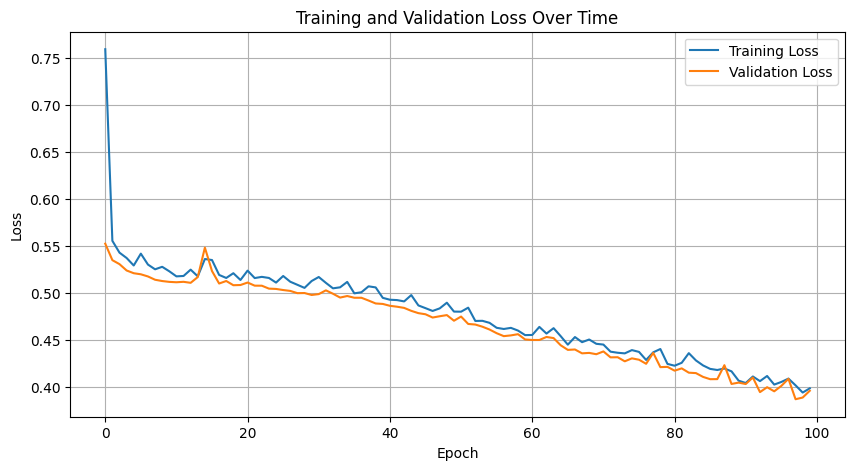

In [94]:
# 1. 데이터 준비
# 정상 데이터 준비 (훈련, 검증, 테스트용 정상 데이터)
normal_dataset = prepare_normal_data('../datas')
# 이상치 데이터 준비
abnormal_dataset = prepare_test_data('../datas')

# 2. 테스트 세트 구성
# 정상 테스트 데이터와 이상치 데이터 합치기
test_sequences = np.concatenate([
    normal_dataset['test_normal'],  # 정상 테스트 시퀀스
    abnormal_dataset['abnormal']    # 이상치 시퀀스
])

# 레이블 생성 (0: 정상, 1: 이상)
test_labels = np.concatenate([
    np.zeros(len(normal_dataset['test_normal'])),  # 정상 데이터 레이블
    np.ones(len(abnormal_dataset['abnormal']))     # 이상치 데이터 레이블
])
# Dataset과 DataLoader 생성
train_dataset = SequenceDataset(normal_dataset['train'])
val_dataset = SequenceDataset(normal_dataset['val'])
test_dataset = SequenceDataset(test_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. 모델 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMAutoencoder(
    input_dim=3,          # X, Y, Z 축 데이터
    hidden_dim=64,        # 히든 레이어 차원
    seq_length=30,        # 시퀀스 길이
    n_layers=2,           # LSTM 레이어 수
    dropout=0.2
).to(device)

# 3. 모델 학습
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,
    learning_rate=1e-3,
    device=device,
    patience=10,
    model_save_path='../models/autoencoder.pth'
)

/tmp/ipykernel_74509/3731417839.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


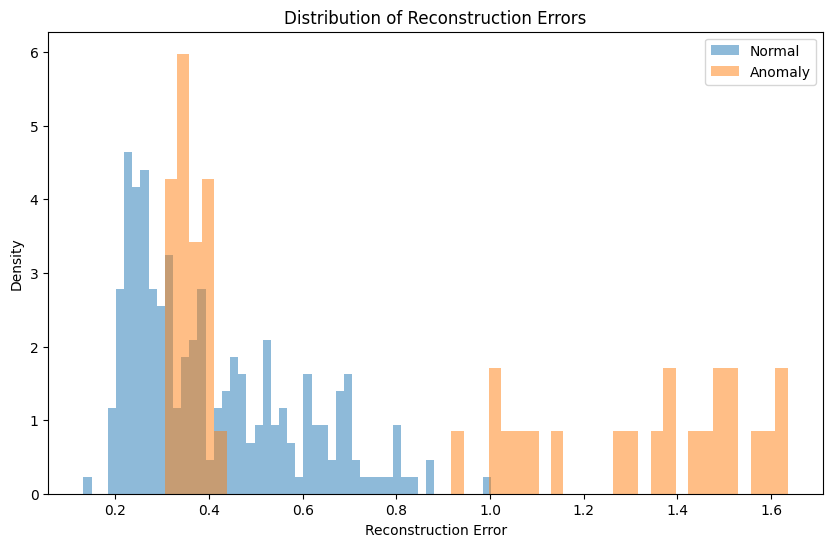

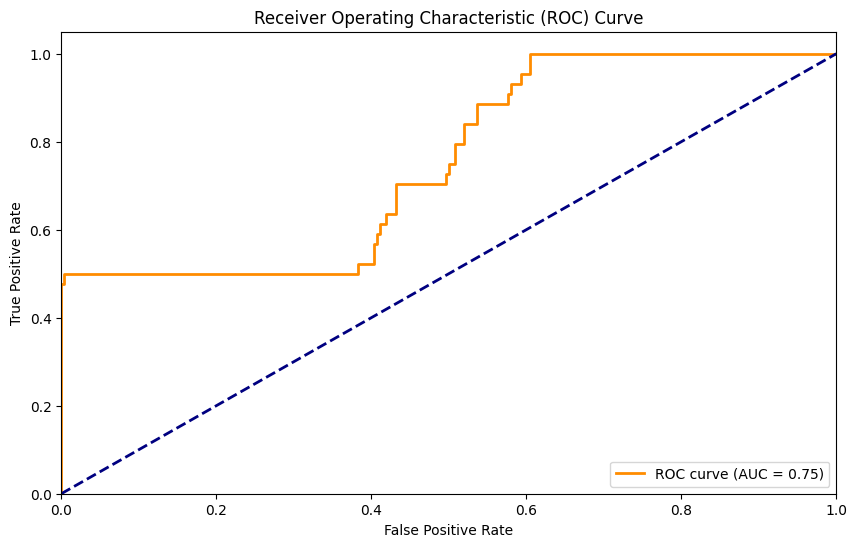

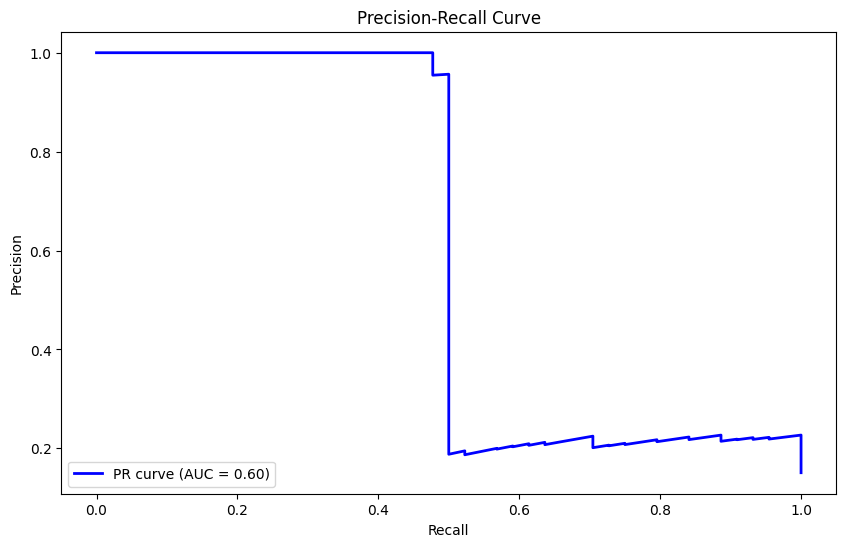

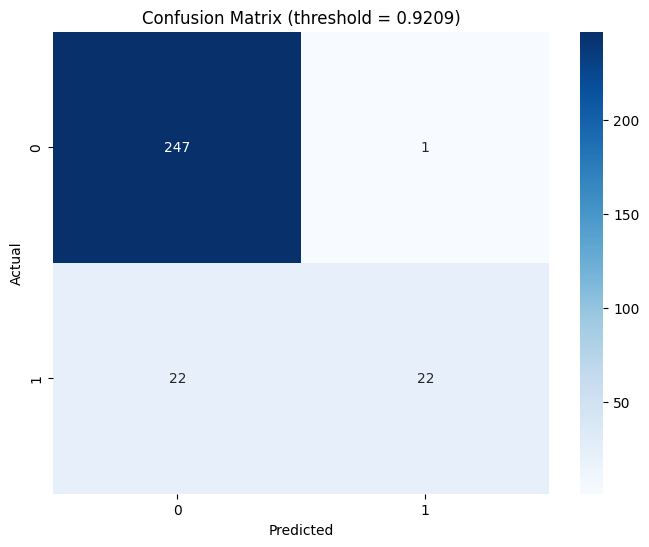


Performance Metrics:
Optimal Threshold: 0.9209
Accuracy: 0.9212
Precision: 0.9565
Recall: 0.5000
F1 Score: 0.6567
ROC AUC: 0.7543
PR AUC: 0.6050

Evaluation Results:
Optimal Threshold: 0.9209
ROC AUC: 0.7543
PR AUC: 0.6050
F1 Score: 0.6567


In [95]:
# 4. 최상의 모델 불러오기 (train_model 함수에서 저장된 모델)
model = load_trained_model(
    model=model,
    model_path='../models/autoencoder.pth',
    device=device
)

# 5. 모델 평가
results = evaluate_model(
    model=model,
    test_loader=test_loader,
    test_labels=test_labels,
    device=device
)

# 6. 결과 확인
print("\nEvaluation Results:")
print(f"Optimal Threshold: {results['optimal_threshold']:.4f}")
print(f"ROC AUC: {results['roc_auc']:.4f}")
print(f"PR AUC: {results['pr_auc']:.4f}")
print(f"F1 Score: {results['f1_score']:.4f}")

Epoch 1/100: 100%|██████████| 54/54 [00:00<00:00, 515.76it/s]


Epoch [1/100]
  Training Loss: 0.402310
  Validation Loss: 0.399512
  Model saved to ../models/autoencoder.pth


Epoch 2/100: 100%|██████████| 54/54 [00:00<00:00, 533.57it/s]


Epoch [2/100]
  Training Loss: 0.395337
  Validation Loss: 0.386314
  Model saved to ../models/autoencoder.pth


Epoch 3/100: 100%|██████████| 54/54 [00:00<00:00, 547.29it/s]


Epoch [3/100]
  Training Loss: 0.391720
  Validation Loss: 0.381088
  Model saved to ../models/autoencoder.pth


Epoch 4/100: 100%|██████████| 54/54 [00:00<00:00, 637.43it/s]


Epoch [4/100]
  Training Loss: 0.387048
  Validation Loss: 0.383959
  EarlyStopping counter: 1 out of 10


Epoch 5/100: 100%|██████████| 54/54 [00:00<00:00, 654.52it/s]


Epoch [5/100]
  Training Loss: 0.388643
  Validation Loss: 0.384134
  EarlyStopping counter: 2 out of 10


Epoch 6/100: 100%|██████████| 54/54 [00:00<00:00, 581.10it/s]


Epoch [6/100]
  Training Loss: 0.392067
  Validation Loss: 0.378708
  Model saved to ../models/autoencoder.pth


Epoch 7/100: 100%|██████████| 54/54 [00:00<00:00, 602.89it/s]


Epoch [7/100]
  Training Loss: 0.386270
  Validation Loss: 0.382575
  EarlyStopping counter: 1 out of 10


Epoch 8/100: 100%|██████████| 54/54 [00:00<00:00, 602.80it/s]


Epoch [8/100]
  Training Loss: 0.385152
  Validation Loss: 0.376134
  Model saved to ../models/autoencoder.pth


Epoch 9/100: 100%|██████████| 54/54 [00:00<00:00, 545.53it/s]


Epoch [9/100]
  Training Loss: 0.382441
  Validation Loss: 0.376159
  EarlyStopping counter: 1 out of 10


Epoch 10/100: 100%|██████████| 54/54 [00:00<00:00, 507.73it/s]


Epoch [10/100]
  Training Loss: 0.385039
  Validation Loss: 0.377737
  EarlyStopping counter: 2 out of 10


Epoch 11/100: 100%|██████████| 54/54 [00:00<00:00, 574.59it/s]


Epoch [11/100]
  Training Loss: 0.381388
  Validation Loss: 0.376471
  EarlyStopping counter: 3 out of 10


Epoch 12/100: 100%|██████████| 54/54 [00:00<00:00, 552.11it/s]


Epoch [12/100]
  Training Loss: 0.397454
  Validation Loss: 0.377364
  EarlyStopping counter: 4 out of 10


Epoch 13/100: 100%|██████████| 54/54 [00:00<00:00, 542.23it/s]


Epoch [13/100]
  Training Loss: 0.381959
  Validation Loss: 0.369546
  Model saved to ../models/autoencoder.pth


Epoch 14/100: 100%|██████████| 54/54 [00:00<00:00, 578.94it/s]


Epoch [14/100]
  Training Loss: 0.384783
  Validation Loss: 0.381588
  EarlyStopping counter: 1 out of 10


Epoch 15/100: 100%|██████████| 54/54 [00:00<00:00, 610.76it/s]


Epoch [15/100]
  Training Loss: 0.387053
  Validation Loss: 0.370712
  EarlyStopping counter: 2 out of 10


Epoch 16/100: 100%|██████████| 54/54 [00:00<00:00, 611.88it/s]


Epoch [16/100]
  Training Loss: 0.377303
  Validation Loss: 0.371112
  EarlyStopping counter: 3 out of 10


Epoch 17/100: 100%|██████████| 54/54 [00:00<00:00, 522.22it/s]


Epoch [17/100]
  Training Loss: 0.373586
  Validation Loss: 0.369894
  EarlyStopping counter: 4 out of 10


Epoch 18/100: 100%|██████████| 54/54 [00:00<00:00, 624.12it/s]


Epoch [18/100]
  Training Loss: 0.375637
  Validation Loss: 0.367306
  Model saved to ../models/autoencoder.pth


Epoch 19/100: 100%|██████████| 54/54 [00:00<00:00, 699.56it/s]


Epoch [19/100]
  Training Loss: 0.371573
  Validation Loss: 0.367033
  Model saved to ../models/autoencoder.pth


Epoch 20/100: 100%|██████████| 54/54 [00:00<00:00, 555.87it/s]


Epoch [20/100]
  Training Loss: 0.371426
  Validation Loss: 0.365337
  Model saved to ../models/autoencoder.pth


Epoch 21/100: 100%|██████████| 54/54 [00:00<00:00, 629.41it/s]


Epoch [21/100]
  Training Loss: 0.378796
  Validation Loss: 0.384939
  EarlyStopping counter: 1 out of 10


Epoch 22/100: 100%|██████████| 54/54 [00:00<00:00, 600.64it/s]


Epoch [22/100]
  Training Loss: 0.396864
  Validation Loss: 0.370509
  EarlyStopping counter: 2 out of 10


Epoch 23/100: 100%|██████████| 54/54 [00:00<00:00, 616.11it/s]


Epoch [23/100]
  Training Loss: 0.371945
  Validation Loss: 0.368516
  EarlyStopping counter: 3 out of 10


Epoch 24/100: 100%|██████████| 54/54 [00:00<00:00, 621.08it/s]


Epoch [24/100]
  Training Loss: 0.373851
  Validation Loss: 0.362590
  Model saved to ../models/autoencoder.pth


Epoch 25/100: 100%|██████████| 54/54 [00:00<00:00, 635.43it/s]


Epoch [25/100]
  Training Loss: 0.370388
  Validation Loss: 0.368295
  EarlyStopping counter: 1 out of 10


Epoch 26/100: 100%|██████████| 54/54 [00:00<00:00, 540.75it/s]


Epoch [26/100]
  Training Loss: 0.365057
  Validation Loss: 0.360363
  Model saved to ../models/autoencoder.pth


Epoch 27/100: 100%|██████████| 54/54 [00:00<00:00, 633.52it/s]


Epoch [27/100]
  Training Loss: 0.366940
  Validation Loss: 0.362999
  EarlyStopping counter: 1 out of 10


Epoch 28/100: 100%|██████████| 54/54 [00:00<00:00, 595.02it/s]


Epoch [28/100]
  Training Loss: 0.386659
  Validation Loss: 0.371040
  EarlyStopping counter: 2 out of 10


Epoch 29/100: 100%|██████████| 54/54 [00:00<00:00, 518.88it/s]


Epoch [29/100]
  Training Loss: 0.369510
  Validation Loss: 0.368866
  EarlyStopping counter: 3 out of 10


Epoch 30/100: 100%|██████████| 54/54 [00:00<00:00, 610.25it/s]


Epoch [30/100]
  Training Loss: 0.374789
  Validation Loss: 0.364061
  EarlyStopping counter: 4 out of 10


Epoch 31/100: 100%|██████████| 54/54 [00:00<00:00, 657.23it/s]


Epoch [31/100]
  Training Loss: 0.369067
  Validation Loss: 0.354311
  Model saved to ../models/autoencoder.pth


Epoch 32/100: 100%|██████████| 54/54 [00:00<00:00, 662.09it/s]


Epoch [32/100]
  Training Loss: 0.368625
  Validation Loss: 0.355507
  EarlyStopping counter: 1 out of 10


Epoch 33/100: 100%|██████████| 54/54 [00:00<00:00, 684.70it/s]


Epoch [33/100]
  Training Loss: 0.363041
  Validation Loss: 0.355220
  EarlyStopping counter: 2 out of 10


Epoch 34/100: 100%|██████████| 54/54 [00:00<00:00, 601.82it/s]


Epoch [34/100]
  Training Loss: 0.360873
  Validation Loss: 0.352808
  Model saved to ../models/autoencoder.pth


Epoch 35/100: 100%|██████████| 54/54 [00:00<00:00, 591.44it/s]


Epoch [35/100]
  Training Loss: 0.362984
  Validation Loss: 0.359202
  EarlyStopping counter: 1 out of 10


Epoch 36/100: 100%|██████████| 54/54 [00:00<00:00, 598.55it/s]


Epoch [36/100]
  Training Loss: 0.367536
  Validation Loss: 0.351274
  Model saved to ../models/autoencoder.pth


Epoch 37/100: 100%|██████████| 54/54 [00:00<00:00, 540.20it/s]


Epoch [37/100]
  Training Loss: 0.354609
  Validation Loss: 0.351105
  Model saved to ../models/autoencoder.pth


Epoch 38/100: 100%|██████████| 54/54 [00:00<00:00, 627.80it/s]


Epoch [38/100]
  Training Loss: 0.358440
  Validation Loss: 0.357735
  EarlyStopping counter: 1 out of 10


Epoch 39/100: 100%|██████████| 54/54 [00:00<00:00, 550.24it/s]


Epoch [39/100]
  Training Loss: 0.353794
  Validation Loss: 0.352993
  EarlyStopping counter: 2 out of 10


Epoch 40/100: 100%|██████████| 54/54 [00:00<00:00, 631.68it/s]


Epoch [40/100]
  Training Loss: 0.349726
  Validation Loss: 0.350345
  Model saved to ../models/autoencoder.pth


Epoch 41/100: 100%|██████████| 54/54 [00:00<00:00, 631.30it/s]


Epoch [41/100]
  Training Loss: 0.349275
  Validation Loss: 0.357791
  EarlyStopping counter: 1 out of 10


Epoch 42/100: 100%|██████████| 54/54 [00:00<00:00, 592.76it/s]


Epoch [42/100]
  Training Loss: 0.357044
  Validation Loss: 0.358748
  EarlyStopping counter: 2 out of 10


Epoch 43/100: 100%|██████████| 54/54 [00:00<00:00, 571.67it/s]


Epoch [43/100]
  Training Loss: 0.364543
  Validation Loss: 0.347821
  Model saved to ../models/autoencoder.pth


Epoch 44/100: 100%|██████████| 54/54 [00:00<00:00, 510.03it/s]


Epoch [44/100]
  Training Loss: 0.351798
  Validation Loss: 0.350651
  EarlyStopping counter: 1 out of 10


Epoch 45/100: 100%|██████████| 54/54 [00:00<00:00, 686.31it/s]


Epoch [45/100]
  Training Loss: 0.345075
  Validation Loss: 0.344068
  Model saved to ../models/autoencoder.pth


Epoch 46/100: 100%|██████████| 54/54 [00:00<00:00, 594.52it/s]


Epoch [46/100]
  Training Loss: 0.350020
  Validation Loss: 0.349199
  EarlyStopping counter: 1 out of 10


Epoch 47/100: 100%|██████████| 54/54 [00:00<00:00, 631.72it/s]


Epoch [47/100]
  Training Loss: 0.360476
  Validation Loss: 0.342075
  Model saved to ../models/autoencoder.pth


Epoch 48/100: 100%|██████████| 54/54 [00:00<00:00, 569.34it/s]


Epoch [48/100]
  Training Loss: 0.350665
  Validation Loss: 0.340496
  Model saved to ../models/autoencoder.pth


Epoch 49/100: 100%|██████████| 54/54 [00:00<00:00, 616.93it/s]


Epoch [49/100]
  Training Loss: 0.341814
  Validation Loss: 0.342397
  EarlyStopping counter: 1 out of 10


Epoch 50/100: 100%|██████████| 54/54 [00:00<00:00, 642.80it/s]


Epoch [50/100]
  Training Loss: 0.340292
  Validation Loss: 0.339729
  Model saved to ../models/autoencoder.pth


Epoch 51/100: 100%|██████████| 54/54 [00:00<00:00, 513.84it/s]


Epoch [51/100]
  Training Loss: 0.336027
  Validation Loss: 0.338706
  Model saved to ../models/autoencoder.pth


Epoch 52/100: 100%|██████████| 54/54 [00:00<00:00, 610.14it/s]


Epoch [52/100]
  Training Loss: 0.340838
  Validation Loss: 0.337614
  Model saved to ../models/autoencoder.pth


Epoch 53/100: 100%|██████████| 54/54 [00:00<00:00, 608.71it/s]


Epoch [53/100]
  Training Loss: 0.341086
  Validation Loss: 0.338073
  EarlyStopping counter: 1 out of 10


Epoch 54/100: 100%|██████████| 54/54 [00:00<00:00, 611.24it/s]


Epoch [54/100]
  Training Loss: 0.341357
  Validation Loss: 0.357076
  EarlyStopping counter: 2 out of 10


Epoch 55/100: 100%|██████████| 54/54 [00:00<00:00, 662.71it/s]


Epoch [55/100]
  Training Loss: 0.343004
  Validation Loss: 0.350283
  EarlyStopping counter: 3 out of 10


Epoch 56/100: 100%|██████████| 54/54 [00:00<00:00, 670.07it/s]


Epoch [56/100]
  Training Loss: 0.333360
  Validation Loss: 0.349665
  EarlyStopping counter: 4 out of 10


Epoch 57/100: 100%|██████████| 54/54 [00:00<00:00, 566.21it/s]


Epoch [57/100]
  Training Loss: 0.333246
  Validation Loss: 0.331299
  Model saved to ../models/autoencoder.pth


Epoch 58/100: 100%|██████████| 54/54 [00:00<00:00, 667.13it/s]


Epoch [58/100]
  Training Loss: 0.329362
  Validation Loss: 0.330876
  Model saved to ../models/autoencoder.pth


Epoch 59/100: 100%|██████████| 54/54 [00:00<00:00, 600.82it/s]


Epoch [59/100]
  Training Loss: 0.332382
  Validation Loss: 0.352464
  EarlyStopping counter: 1 out of 10


Epoch 60/100: 100%|██████████| 54/54 [00:00<00:00, 595.49it/s]


Epoch [60/100]
  Training Loss: 0.370825
  Validation Loss: 0.379929
  EarlyStopping counter: 2 out of 10


Epoch 61/100: 100%|██████████| 54/54 [00:00<00:00, 519.36it/s]


Epoch [61/100]
  Training Loss: 0.357761
  Validation Loss: 0.335761
  EarlyStopping counter: 3 out of 10


Epoch 62/100: 100%|██████████| 54/54 [00:00<00:00, 532.02it/s]


Epoch [62/100]
  Training Loss: 0.350187
  Validation Loss: 0.332206
  EarlyStopping counter: 4 out of 10


Epoch 63/100: 100%|██████████| 54/54 [00:00<00:00, 557.92it/s]


Epoch [63/100]
  Training Loss: 0.327696
  Validation Loss: 0.324687
  Model saved to ../models/autoencoder.pth


Epoch 64/100: 100%|██████████| 54/54 [00:00<00:00, 666.32it/s]


Epoch [64/100]
  Training Loss: 0.323982
  Validation Loss: 0.325954
  EarlyStopping counter: 1 out of 10


Epoch 65/100: 100%|██████████| 54/54 [00:00<00:00, 547.42it/s]


Epoch [65/100]
  Training Loss: 0.325030
  Validation Loss: 0.324200
  Model saved to ../models/autoencoder.pth


Epoch 66/100: 100%|██████████| 54/54 [00:00<00:00, 650.81it/s]


Epoch [66/100]
  Training Loss: 0.326559
  Validation Loss: 0.340608
  EarlyStopping counter: 1 out of 10


Epoch 67/100: 100%|██████████| 54/54 [00:00<00:00, 507.15it/s]


Epoch [67/100]
  Training Loss: 0.327668
  Validation Loss: 0.324891
  EarlyStopping counter: 2 out of 10


Epoch 68/100: 100%|██████████| 54/54 [00:00<00:00, 542.40it/s]


Epoch [68/100]
  Training Loss: 0.317967
  Validation Loss: 0.341435
  EarlyStopping counter: 3 out of 10


Epoch 69/100: 100%|██████████| 54/54 [00:00<00:00, 628.52it/s]


Epoch [69/100]
  Training Loss: 0.320030
  Validation Loss: 0.411380
  EarlyStopping counter: 4 out of 10


Epoch 70/100: 100%|██████████| 54/54 [00:00<00:00, 645.84it/s]


Epoch [70/100]
  Training Loss: 0.372447
  Validation Loss: 0.327557
  EarlyStopping counter: 5 out of 10


Epoch 71/100: 100%|██████████| 54/54 [00:00<00:00, 548.54it/s]


Epoch [71/100]
  Training Loss: 0.320658
  Validation Loss: 0.323947
  Model saved to ../models/autoencoder.pth


Epoch 72/100: 100%|██████████| 54/54 [00:00<00:00, 509.99it/s]


Epoch [72/100]
  Training Loss: 0.319742
  Validation Loss: 0.358254
  EarlyStopping counter: 1 out of 10


Epoch 73/100: 100%|██████████| 54/54 [00:00<00:00, 583.19it/s]


Epoch [73/100]
  Training Loss: 0.340150
  Validation Loss: 0.324044
  EarlyStopping counter: 2 out of 10


Epoch 74/100: 100%|██████████| 54/54 [00:00<00:00, 533.62it/s]


Epoch [74/100]
  Training Loss: 0.317015
  Validation Loss: 0.329170
  EarlyStopping counter: 3 out of 10


Epoch 75/100: 100%|██████████| 54/54 [00:00<00:00, 605.45it/s]


Epoch [75/100]
  Training Loss: 0.315586
  Validation Loss: 0.316803
  Model saved to ../models/autoencoder.pth


Epoch 76/100: 100%|██████████| 54/54 [00:00<00:00, 555.61it/s]


Epoch [76/100]
  Training Loss: 0.317317
  Validation Loss: 0.315668
  Model saved to ../models/autoencoder.pth


Epoch 77/100: 100%|██████████| 54/54 [00:00<00:00, 669.42it/s]


Epoch [77/100]
  Training Loss: 0.312351
  Validation Loss: 0.324725
  EarlyStopping counter: 1 out of 10


Epoch 78/100: 100%|██████████| 54/54 [00:00<00:00, 502.64it/s]


Epoch [78/100]
  Training Loss: 0.313789
  Validation Loss: 0.311493
  Model saved to ../models/autoencoder.pth


Epoch 79/100: 100%|██████████| 54/54 [00:00<00:00, 658.22it/s]


Epoch [79/100]
  Training Loss: 0.308810
  Validation Loss: 0.338873
  EarlyStopping counter: 1 out of 10


Epoch 80/100: 100%|██████████| 54/54 [00:00<00:00, 679.16it/s]


Epoch [80/100]
  Training Loss: 0.308858
  Validation Loss: 0.316285
  EarlyStopping counter: 2 out of 10


Epoch 81/100: 100%|██████████| 54/54 [00:00<00:00, 560.30it/s]


Epoch [81/100]
  Training Loss: 0.305091
  Validation Loss: 0.307148
  Model saved to ../models/autoencoder.pth


Epoch 82/100: 100%|██████████| 54/54 [00:00<00:00, 573.35it/s]


Epoch [82/100]
  Training Loss: 0.298259
  Validation Loss: 0.312128
  EarlyStopping counter: 1 out of 10


Epoch 83/100: 100%|██████████| 54/54 [00:00<00:00, 516.51it/s]


Epoch [83/100]
  Training Loss: 0.301731
  Validation Loss: 0.309596
  EarlyStopping counter: 2 out of 10


Epoch 84/100: 100%|██████████| 54/54 [00:00<00:00, 591.04it/s]


Epoch [84/100]
  Training Loss: 0.305006
  Validation Loss: 0.316527
  EarlyStopping counter: 3 out of 10


Epoch 85/100: 100%|██████████| 54/54 [00:00<00:00, 587.82it/s]


Epoch [85/100]
  Training Loss: 0.302411
  Validation Loss: 0.312530
  EarlyStopping counter: 4 out of 10


Epoch 86/100: 100%|██████████| 54/54 [00:00<00:00, 500.40it/s]


Epoch [86/100]
  Training Loss: 0.304551
  Validation Loss: 0.312840
  EarlyStopping counter: 5 out of 10


Epoch 87/100: 100%|██████████| 54/54 [00:00<00:00, 524.16it/s]


Epoch [87/100]
  Training Loss: 0.307509
  Validation Loss: 0.309423
  EarlyStopping counter: 6 out of 10


Epoch 88/100: 100%|██████████| 54/54 [00:00<00:00, 657.74it/s]


Epoch [88/100]
  Training Loss: 0.299192
  Validation Loss: 0.326977
  EarlyStopping counter: 7 out of 10


Epoch 89/100: 100%|██████████| 54/54 [00:00<00:00, 629.43it/s]


Epoch [89/100]
  Training Loss: 0.303933
  Validation Loss: 0.324739
  EarlyStopping counter: 8 out of 10


Epoch 90/100: 100%|██████████| 54/54 [00:00<00:00, 507.34it/s]


Epoch [90/100]
  Training Loss: 0.302201
  Validation Loss: 0.312296
  EarlyStopping counter: 9 out of 10


Epoch 91/100: 100%|██████████| 54/54 [00:00<00:00, 572.05it/s]

Epoch [91/100]
  Training Loss: 0.297666
  Validation Loss: 0.346590
  EarlyStopping counter: 10 out of 10
Early stopping triggered


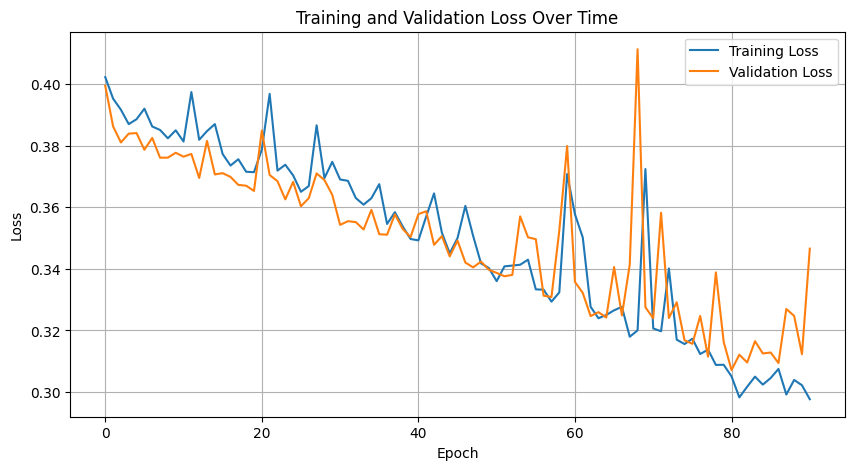

/tmp/ipykernel_74509/3731417839.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


FileNotFoundError: [Errno 2] No such file or directory: 'models/autoencoder.pth'

In [96]:
# 모델 훈련
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,
    learning_rate=1e-3,
    patience=10
)

# 저장된 최상의 모델 로드
model = load_trained_model(model, 'models/autoencoder.pth')